In [1]:
import numpy as np
# Train a model to classify real pulses vs. noise
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import awkward as ak
from tensorflow.keras.layers import Dropout
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
num_events = 50000
num_samples = 10
xmin = 1
xmax = 10

In [3]:
def plot_timesamples(ax, time, emsignal_list, noisedata_list):
    #fig, ax = plt.subplots()
    for i, emsignal in enumerate(emsignal_list):
        noisedata = noisedata_list[i][1:]
        ax.plot(time, emsignal[1:], label=f'EM pulse' if i==1 else None, color='blue')
        ax.plot(time, noisedata, label=f'noise'  if i==1 else None,color='orange')
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('Amplitude (arb. units)')
    ax.legend()

[[-0.13500901 -0.06486101 -0.24207319 ... -0.33857177 -0.65531789
  -0.59965165]
 [-1.         -0.44654846  0.04011444 ... -0.00468594  0.082898
   0.16267521]
 [ 0.12382481  0.06464252  0.20023386 ...  0.91687229  1.
   0.97295958]
 ...
 [ 0.03826011 -0.74802831 -0.74012889 ...  0.94438525  0.71223759
   0.53373214]
 [ 0.56940722  0.05372832  0.26732516 ...  0.17160948  0.07397752
  -0.28824042]
 [-0.43647409 -0.26998941  0.17765244 ...  0.76181932  0.87472013
   0.83904154]]
Printing y_real
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


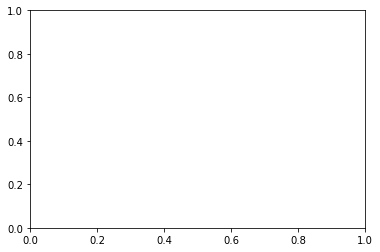

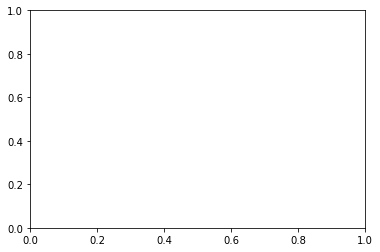

In [4]:
import uproot
### Energy = 1 GeV
dirName = "noise_0p15/0p15GeV/"
root_file = uproot.open(f"/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/data/outputPSWithNoPU_withNoise_0.150000_0.15_v1.root")
tree = root_file["Samples"]
arrays = tree.arrays(["samples", "ysamples","samplesNoise","ysamplesNoise"])
X_real = ak.to_numpy(arrays["samples"])
y_real = ak.to_numpy(arrays["ysamples"])
X_noise = ak.to_numpy(arrays["samplesNoise"])
y_noise = ak.to_numpy(arrays["ysamplesNoise"])

print(X_real) 
print("Printing y_real")
print(y_real)

data = np.concatenate([X_real, X_noise]) ### makes it [2*num_events,num_samples]
labels = np.concatenate([y_real,y_noise])

# Shuffle data and labels together
## Important to shuffle since I take some fraction of events so it should not happen that all the real events 
## are cluttered at the beginning
shuffle_indices = np.random.permutation(len(data))
data = data[shuffle_indices]
labels = labels[shuffle_indices]

fig, ax = plt.subplots()
import awkward as ak

num_events = ak.num(X_real, axis=0)
t_events = np.zeros((num_events, num_samples))
for i in range(num_events):
    t_event = np.linspace(xmin, xmax, 10)
    t_events[i] = t_event
###replace this block with actual time variable

fig, ax = plt.subplots()
ev_numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9 , 10, 100, 200, 300]# list of event numbers to plot
#ev_numbers = [1500]
emsignal_list = [X_real[ev_number] for ev_number in ev_numbers]
noisedata_list = [X_noise[ev_number] for ev_number in ev_numbers]
#plot_timesamples(ax, t_events[ev_numbers[0]], emsignal_list, noisedata_list)
#plt.show()

In [6]:
import awkward as ak

num_events_data = ak.num(data, axis=0)
print(f'number of rows in data is {num_events_data}')


ntimeSamples_data = ak.num(data, axis=1)
print(f'number of rows in data is {ntimeSamples_data[0]}') ## just take the 0th event

# Split into train and test sets
train_size = int(0.7 * num_events_data) ###times 2 because the noise is also in the same dataset, so it is 2*num_events
train_data = data[:train_size]
train_labels = labels[:train_size]
test_data = data[train_size:]
test_labels = labels[train_size:]

print(f'Size of training data is {train_size}')

'''
print(train_size)
print(train_data)
print(test_data)
'''

print(f'number of elements in data : training data : test data : {len(data)} : {len(train_data)} : {len(test_data)}')

number of rows in data is 200000
number of rows in data is 11
Size of training data is 140000
number of elements in data : training data : test data : 200000 : 140000 : 60000


In [7]:
x_train = train_data
y_train = train_labels
#n_classes = len(np.unique(y_train))
x_test = test_data
y_test = test_labels

In [8]:
#x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
#x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [9]:
y_train = y_train.reshape((y_train.shape[0],1))
y_test = y_test.reshape((y_test.shape[0],1))

In [10]:
from tensorflow import keras
from tensorflow.keras import layers

In [11]:
class Time2Vec(layers.Layer):

    def __init__(self, kernel, activation):
        super(Time2Vec, self).__init__()
        if activation in ["sin", "cos"]:
            activation = {"sin": tf.math.sin, "cos": tf.math.cos}[activation]

        self.k = kernel - 1
        self.p_activation = activation

    def build(self, input_shape):

        # Linear component
        self.w_b = self.add_weight(
            shape=(1, input_shape[1], 1), initializer="uniform", trainable=True
        )

        self.b_b = self.add_weight(
            shape=(1, input_shape[1], 1), initializer="uniform", trainable=True
        )

        # Periodic components
        self.freq = self.add_weight(
            shape=(1, input_shape[1], self.k), initializer="uniform", trainable=True
        )

        self.phase = self.add_weight(
            shape=(1, input_shape[1], self.k), initializer="uniform", trainable=True
        )

        #super().build(input_shape)

    def call(self, inputs: tf.Tensor, **kwargs) -> tf.Tensor:

        inputs = tf.expand_dims(inputs, axis=-1) #(batch_size, feature_size, 1)

        # Linear components
        lin = (
            # Multiply each time dimension with the corresponding linear time component
            tf.multiply(inputs, self.w_b)
            # Bias component for each time dimension
            + self.b_b
        )

        # Periodic components
        # Multiply each time dimension (M, D, H, mins, etc.) with the corresponding frequency vector
        per = tf.multiply(tf.tile(inputs, multiples=[1, 1, self.k]), self.freq)
        # Phase vector for each time dimension
        per = self.p_activation(per + self.phase)
        return tf.concat([lin, per], -1)

    def compute_output_shape(self, input_shape: tuple) -> tuple:
       
        return (input_shape[0], input_shape[1], self.k + 1)


In [12]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [13]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    x = Time2Vec(64, "sin")(x)
    print("After Time2Vec embedding:", x.shape)
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

In [14]:
input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

#model.compile(
#    loss="sparse_categorical_crossentropy",
#    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
#    metrics=["sparse_categorical_accuracy"],
#)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary(expand_nested = True)

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=64,
    callbacks=callbacks,
)

# Save the model to a file
#model.save('/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/model/timeSeries_TransformerNetorkmodel_v1.h5')
#test_loss, test_acc = model.evaluate(x_test, y_test)
#print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')

After Time2Vec embedding: (None, 11, 64)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 11)]         0           []                               
                                                                                                  
 time2_vec (Time2Vec)           (None, 11, 64)       1408        ['input_1[0][0]']                
                                                                                                  
 layer_normalization (LayerNorm  (None, 11, 64)      128         ['time2_vec[0][0]']              
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 11, 64)      

                                                                                                  
 tf.__operators__.add_6 (TFOpLa  (None, 11, 64)      0           ['dropout_6[0][0]',              
 mbda)                                                            'tf.__operators__.add_5[0][0]'] 
                                                                                                  
 layer_normalization_7 (LayerNo  (None, 11, 64)      128         ['tf.__operators__.add_6[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv1d_6 (Conv1D)              (None, 11, 4)        260         ['layer_normalization_7[0][0]']  
                                                                                                  
 dropout_7 (Dropout)            (None, 11, 4)        0           ['conv1d_6[0][0]']               
          

In [25]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')

1875/1875 [==============================] - 15s 8ms/step - loss: 0.5036 - accuracy: 0.7589
Test loss: 0.5036376118659973, Test accuracy: 0.7589333057403564


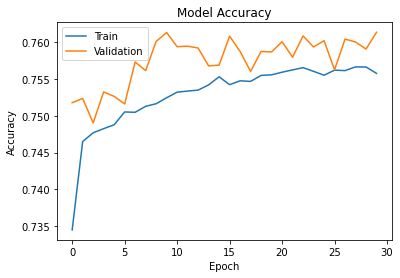

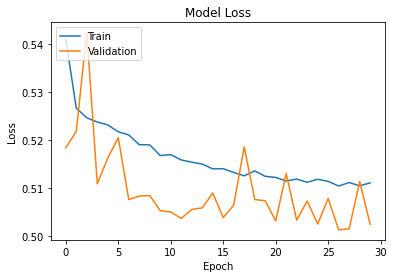

In [26]:
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

60000 and 60000
 predictions are [0.58231664 0.6704384  0.3244062  ... 0.61542314 0.17932798 0.08542572]


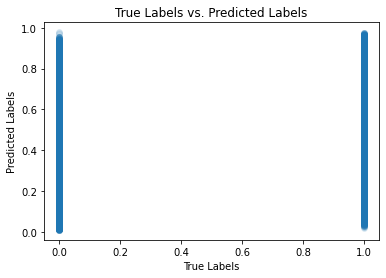

In [27]:
# Make predictions on test data
predictions = model.predict(x_test).flatten()
# Convert predictions to binary labels
binary_predictions = (predictions > 0.5).astype(int)

print(f'{len(y_test)} and {len(binary_predictions)}')
print(f" predictions are {predictions}")
# Create scatter plot of true labels vs. predicted labels
plt.scatter(y_test, predictions, alpha=0.1)
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('True Labels vs. Predicted Labels')
plt.show()

test labels are: [1. 1. 0. ... 1. 1. 0.]
[0.3244062  0.2569985  0.5908317  ... 0.09029094 0.20265551 0.08542572]
[0.58231664 0.6704384  0.87395734 ... 0.8992983  0.61542314 0.17932798]


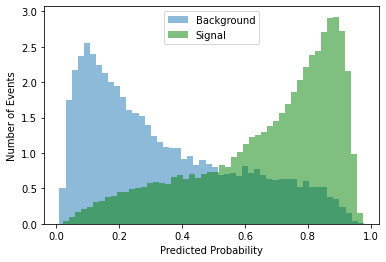

In [28]:

print(f'test labels are: {y_test[:,0]}')

# Create separate arrays for background and signal predictions
bkg_preds = predictions[y_test[:,0] == 0]
sig_preds = predictions[y_test[:,0] == 1]

print(bkg_preds)
print(sig_preds)
# Plot the predicted probabilities
plt.hist(bkg_preds, bins=50, label='Background', alpha=0.5, density=True)
plt.hist(sig_preds, bins=50, label='Signal', alpha=0.5, density=True, color='green')
plt.xlabel('Predicted Probability')
plt.ylabel('Number of Events')
plt.legend(loc='upper center')
#plt.ylim(top=100)
plt.show()

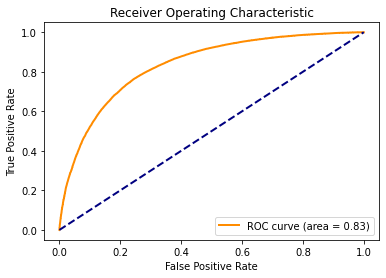

In [29]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
#plt.xlim([0.9, 1])
#plt.ylim([0.999, 1.005])
plt.show()

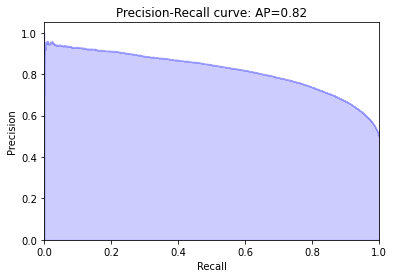

In [30]:
### precision recall curve
# Calculate precision-recall curve and average precision
precision, recall, _ = precision_recall_curve(y_test, predictions)
average_precision = average_precision_score(y_test, predictions)

# Plot precision-recall curve
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()